# Student Competition - Exploratory Data Analysis
## Task time predictions from RoboMission

Data source and explanation:
- https://github.com/adaptive-learning/adaptive-learning-research/tree/master/data/robomission-2019-02-09
- check out https://colab.research.google.com/drive/1LJIbWajN9eHxn1lCJ1Jq0EZsb60YSHH-#scrollTo=3ubmmMfdEdtl

## Basic info
- Users solve tasks, predict the time to solve: Log of `time` in `attempts.csv`.
- metric: RMSE

## Approach

### Phase 1: Basic EDA and Baselines
1. Baseline 1: global mean
2. Baseline 2: Mean per task
3. Baseline 3: Mean per user

### Phase 2: EDA and Feature engineering Using time series information
4. Cluster users based on when they're solving - school kid (during school working hours) / teacher (late in the evening) / self-study (weekends)
    - Add features expressing: `isWeekend`, `isHolidays`, `isSchoolWorkingHours`, ``
5. Futher considerations
    - first task solved after a long break?
    - school situation: just before the bell rings? morning/afternoon?

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [130]:
from robomission import *
from helpers import *
import seaborn as sns

# Phase 1: Basic EDA

## Data loading, initial checks
- basic info
- check out null values - not solved items

In [4]:
DATA = load_attempts()
df_train = DATA['attempts'].copy()
df_test = DATA['attempts_reporting'].copy()

In [5]:
DATA['performance_columns']

Index(['solved', 'time', 'response_time_sec', 'executions', 'edits',
       'program'],
      dtype='object')

In [6]:
print(f"Numerical features: {df_train.select_dtypes(include = ['float64', 'int64']).columns.values}")
print(f"Categorical features: {df_train.select_dtypes(include = ['object']).columns.values}")

Numerical features: ['event_order' 'student' 'item' 'time' 'response_time_sec' 'executions'
 'edits']
Categorical features: ['item_setting' 'item_solution' 'item_order' 'program']


In [7]:
df_train.head()

event_order  student  item                            start  \
id                                                                
4             1       29     2 2017-11-10 12:20:05.152265+00:00   
5             2       29    12 2017-11-10 12:20:32.155447+00:00   
6             3       29    10 2017-11-10 12:20:54.080259+00:00   
7             4       29    14 2017-11-10 12:21:06.966330+00:00   
8             5       29    11 2017-11-10 12:21:33.061485+00:00   

                                         item_setting item_solution  \
id                                                                    
4   {'toolbox': ['fly'], 'fields': 'b|bM|b|bM|b;kM...           lrf   
5   {'toolbox': ['fly', 'shoot'], 'fields': 'b|b|b...          rrff   
6   {'toolbox': ['fly', 'shoot'], 'fields': 'b|bA|...           fsf   
7   {'toolbox': ['fly'], 'fields': 'bM|b|bD|b|b;k|...           frl   
8   {'toolbox': ['fly', 'shoot', 'repeat'], 'lengt...        R4{fs}   

   item_order  solved      time  response_time_sec  executions  edits program  
id                                                                             
4   (1, 2, 4)    True  3.178054                 24           2      3     lrf  
5   (2, 2, 1)    True  2.890372                 18           1      4    rrff  
6   (2, 1, 1)    True  2.302585                 10           1      3     sff  
7   (1, 3, 2)    True  2.890372                 18           1      3     frl  
8   (3, 1, 1)    True  3.295837                 27           1      4  R4{fs}

## Difficulty of tasks

### 1. What's the percentage of solved vs. not solved tasks? 

In [8]:
len(list(df_train[df_train["time"].isnull()].values))

11743

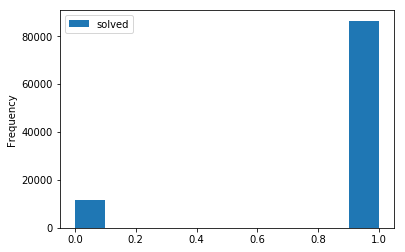

In [9]:
df_train[["solved"]].astype(float).plot.hist()

#### Are the missing values in 'time' associated with tasks that were not solved?

In [11]:
def find_nans(df):
    return (df.isnull().sum().sort_index()/len(df)).sort_values(ascending=False)
find_nans(df_train)
(df_train[df_train["time"].isnull()]["solved"] == False).all()

True

### 2. What's the mean time spent on a task?

In [12]:
time_spent_per_task = {}
for task_no in list(df_train["item"].unique()):
    time_spent_per_task[task_no] = df_train[df_train["item"] == task_no]["time"].mean()

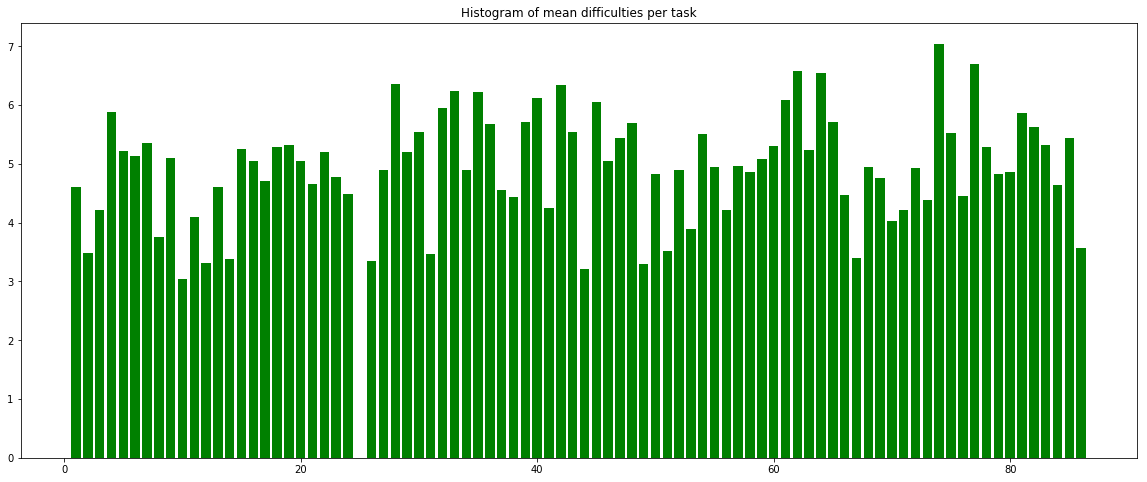

In [13]:
plt.figure(figsize=(20,8))
plt.bar(list(time_spent_per_task.keys()), time_spent_per_task.values(), color='g')
plt.title("Histogram of mean difficulties per task")
plt.show()

### 3. What are the most difficult tasks?

In [14]:
s = [(w,time_spent_per_task[w]) for w in sorted(time_spent_per_task, key=time_spent_per_task.get, reverse=True)]
s[:8]

[(74, 7.045172896398971),
 (77, 6.694450172015149),
 (62, 6.57173287350421),
 (64, 6.542439720606659),
 (28, 6.364521543873684),
 (42, 6.346472888091483),
 (33, 6.24121021315576),
 (35, 6.225088282744749)]

## Skills of students

In [15]:
print(f"There are {len(df_train['student'].unique())} unique students")

There are 6718 unique students


In [16]:
print(f"There are {np.intersect1d(df_test['student'], df_train['student']).size} overlaps of testing-training users")

There are 62 overlaps of testing-training users


In [17]:
time_spent_per_user = {}
time_spent_per_active_user = {}
for student_no in list(df_train["student"].unique()):
    time_spent_per_user[student_no] = df_train[df_train["student"] == student_no]["time"].mean()

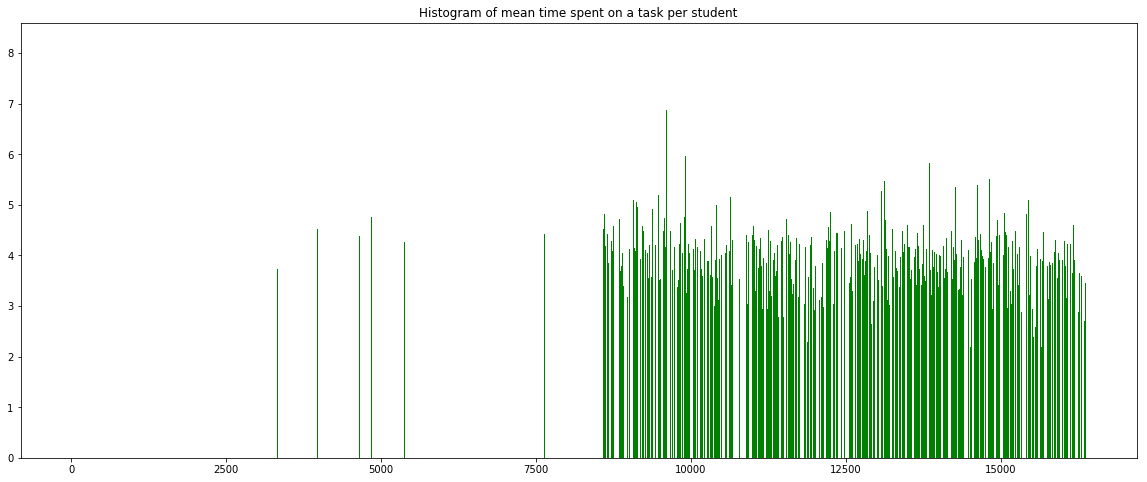

In [18]:
plt.figure(figsize=(20,8))
plt.bar(list(time_spent_per_user.keys()), time_spent_per_user.values(), color='g')
plt.title("Histogram of mean time spent on a task per student")
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.bar(list(time_spent_per_user.keys()), time_spent_per_user.values(), color='g')
plt.title("Histogram of mean time spent on a task per student")
plt.show()

# Phase 2: EDA with time series data

- correlations
    - `time` is correlated with `executions` and `edits`

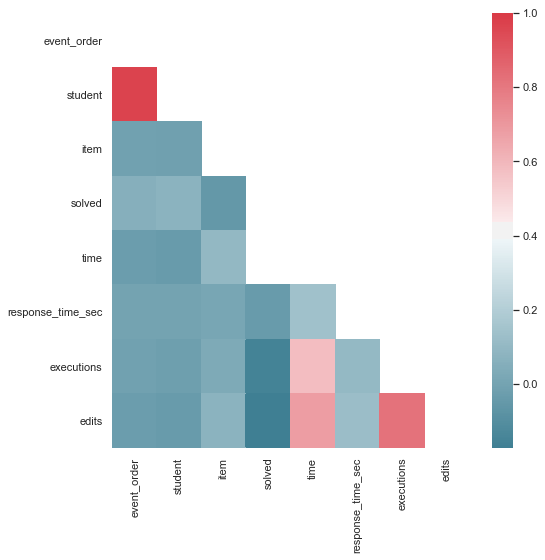

In [19]:
variable_correlations = df_train.corr()
heat_map(variable_correlations)

In [20]:
df_train[["edits"]].describe(include="all")

edits
count  98226.000000
mean      12.907468
std       16.856593
min        0.000000
25%        4.000000
50%        8.000000
75%       15.000000
max      622.000000

In [21]:
df_train[["edits"]][df_train["edits"] < 200].describe(include="all")
# some outliers here? might be worth exploring what makes these data points to have such a big edits number

edits
count  98164.000000
mean      12.751426
std       15.590280
min        0.000000
25%        4.000000
50%        8.000000
75%       15.000000
max      199.000000

In [22]:
df_train[["executions"]].describe(include="all")
# some outliers here? might be worth exploring what makes these data points to have such a big edits number

executions
count  98226.000000
mean       3.516574
std        5.206668
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      199.000000

In [23]:
df_train[["executions"]][df_train["executions"] < 50].describe(include="all")
# some outliers here? might be worth exploring what makes these data points to have such a big edits number

executions
count  98087.000000
mean       3.425581
std        4.543297
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       49.000000

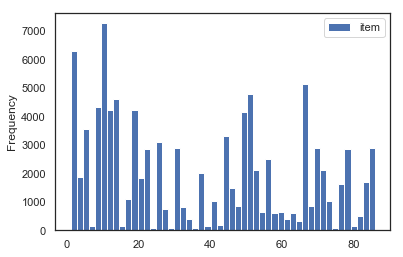

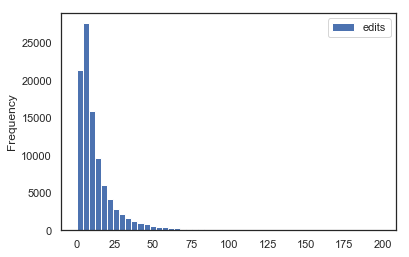

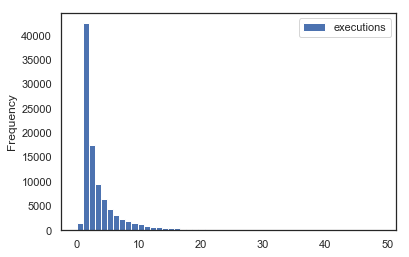

In [24]:
display(df_train[["item"]].astype(float).plot.hist(bins=50))
display(df_train[["edits"]][df_train["edits"] < 200].astype(float).plot.hist(bins=50))
display(df_train[["executions"]][df_train["executions"] < 50].astype(float).plot.hist(bins=50))

In [25]:
numericalize_all(df_train)
add_datepart(df_train, 'start')

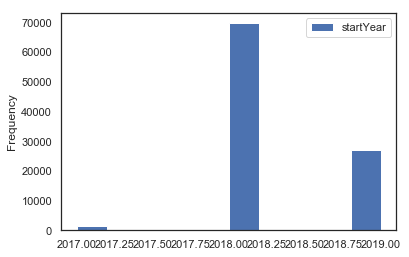

In [26]:
df_train[["startYear"]].plot.hist()

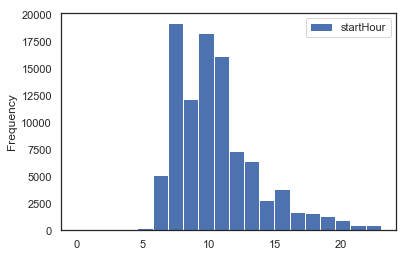

In [27]:
df_train[["startHour"]].plot.hist(bins=20)

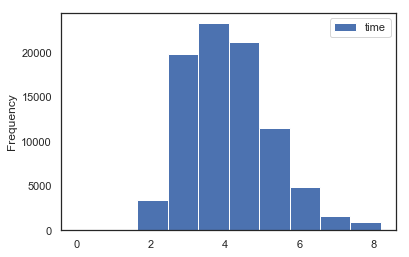

In [28]:
df_train[["time"]].astype(float).plot.hist()

#### Simple Random Forest

In [29]:
# drop unsolved tasks
to_drop = ["time", "response_time_sec", "solved", "start"]
df_train_only_solved = df_train[df_train["solved"] == True]
df_train_only_solved_time = df_train_only_solved[["time"]]
df_train_only_solved = df_train_only_solved.drop(to_drop, axis=1)
len(list(df_train_only_solved.columns.values))

25

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time rf.fit(df_train_only_solved.values, df_train_only_solved_time.values)
print(rf.oob_score_)

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\terez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Wall time: 7.9 s
0.4725634797872015


C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [31]:
indices = np.argsort(rf.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking:')

for f in range(df_train_only_solved.shape[1]):
    print(f"{f+1}. feature: '{df_train_only_solved.columns[indices[f]]} ({rf.feature_importances_[indices[f]]})")

Feature ranking:
1. feature: 'edits (0.647962063540881)
2. feature: 'executions (0.04006908860877785)
3. feature: 'startMinute (0.036868871290606745)
4. feature: 'startSecond (0.036698441896413685)
5. feature: 'student (0.028045558248673448)
6. feature: 'item_order (0.02798273735508581)
7. feature: 'startHour (0.02350985793310388)
8. feature: 'startDay (0.02256042672131353)
9. feature: 'event_order (0.02199710030902325)
10. feature: 'startElapsed (0.019073011883307196)
11. feature: 'startDayofyear (0.01602232038861451)
12. feature: 'item_solution (0.014710869248007482)
13. feature: 'program (0.014618463994991306)
14. feature: 'startDayofweek (0.014413215434206626)
15. feature: 'item_setting (0.012438342022947153)
16. feature: 'item (0.010391542470889293)
17. feature: 'startWeek (0.006885398305518873)
18. feature: 'startMonth (0.003297097736682005)
19. feature: 'startIs_month_end (0.0007581676476686613)
20. feature: 'startIs_month_start (0.0005743683048240557)
21. feature: 'startYear (0

## Time Feature engineering:
- https://cs.wikipedia.org/wiki/%C5%A0koln%C3%AD_rok
- feature engineering - add features connected to school year in czech rep
    - `isSummerHolidays`, `isHolidays`, `isWeekend`, `isMorning/Afternoon/Evening`, `isBeforeBreak`

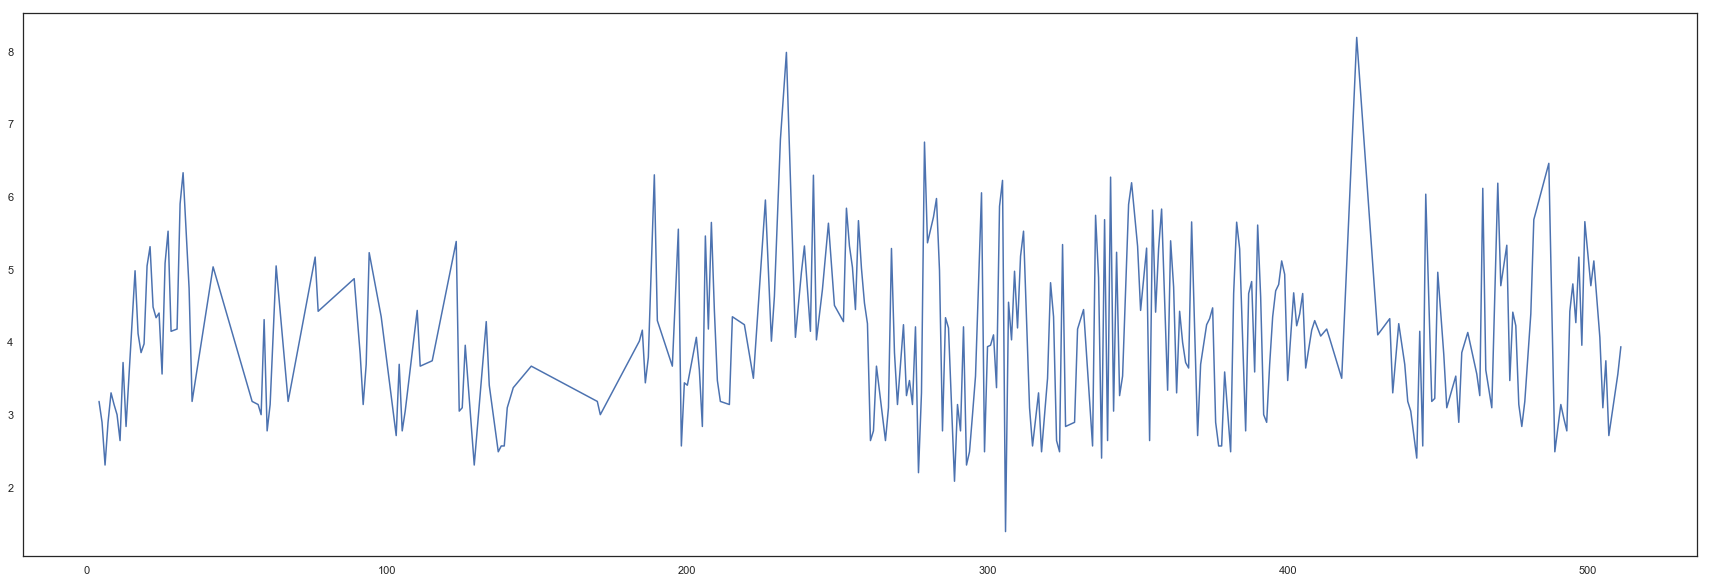

In [186]:
plt.figure(figsize=(30,10))
plt.plot(df_train["time"].dropna()[:300])

In [52]:
for year in list(df["startYear"].unique()):
    for holidays in state_holidays:
        df.loc[(df["startYear"]== year) & (df["startMonth"]== holidays[1]) & (df["startDay"]== holidays[0]), "isStateHolidays"] = True
        
for holidays in state_holidays_year_dependent:
    df.loc[(df["startYear"]== holidays[2]) & (df["startMonth"]== holidays[1]) & (df["startDay"]== holidays[0]), "isStateHolidays"] = True

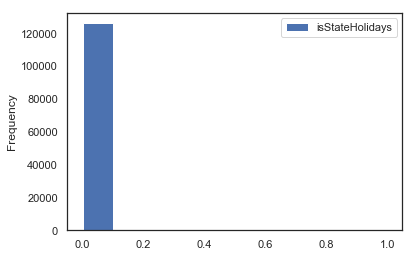

In [53]:
df[["isStateHolidays"]].astype(float).plot.hist()

In [54]:
df[df["isStateHolidays"] == True].shape

(319, 35)

In [209]:
print(f"Mean in state holidays: {df[df['isStateHolidays']==True]['time'].mean()} | Global mean: {df['time'].mean()}")

Mean in state holidays: 4.463004901342146 | Global mean: 4.06747891904924


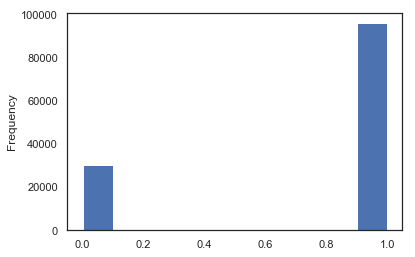

In [55]:
df["isSchoolWorkingHours"] = df["startHour"].between(8,14, inclusive=True)
df["isSchoolWorkingHours"].astype(float).plot.hist()

In [41]:
df[df["isSchoolWorkingHours"] == True].shape

(95952, 32)

In [42]:
df["isSchoolBreak"] = False
school_breaks = [(8,45,55), (9, 40, 59), (10, 45, 55), (11, 40, 50), (12, 35, 45), (13, 30, 40)]
for b in school_breaks:
    df.loc[(df["startHour"] == b[0]) & (df["startMinute"].between(b[1], b[2], inclusive=True)), "isSchoolWorkingHours"] = False
    df.loc[(df["startHour"] == b[0]) & (df["startMinute"].between(b[1], b[2], inclusive=True)), "isSchoolBreak"] = True

In [43]:
df[df["isSchoolWorkingHours"] == True].shape

(80966, 33)

In [44]:
df["isWeekend"] = df["startDayofweek"].between(5,6, inclusive=True)

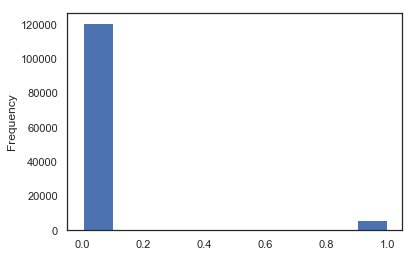

In [45]:
df["isWeekend"].astype(float).plot.hist()

In [46]:
df.loc[(df["isWeekend"]), "isSchoolWorkingHours"] = False
df.loc[(df["isSummerHolidays"]), "isSchoolWorkingHours"] = False
df.loc[(df["isStateHolidays"]), "isSchoolWorkingHours"] = False

In [47]:
df[df["isSchoolWorkingHours"] == True].shape

(77775, 34)

In [213]:
print(f"Mean in isWeekend: {df[df['isWeekend']==True]['time'].mean()} | Global mean: {df['time'].mean()}")

Mean in isWeekend: 4.211065456107835 | Global mean: 4.06747891904924


In [212]:
print(f"Mean in isSummerHolidays: {df[df['isSummerHolidays']==True]['time'].mean()} | Global mean: {df['time'].mean()}")

Mean in isSummerHolidays: 4.166732665701597 | Global mean: 4.06747891904924


In [211]:
print(f"Mean in isSchoolWorkingHours: {df[df['isSchoolWorkingHours']==True]['time'].mean()} | Global mean: {df['time'].mean()}")

Mean in isSchoolWorkingHours: 4.057956417504666 | Global mean: 4.06747891904924


In [48]:
df["isShortlyBeforeBreak"] = False
before_time_mins = 10
for b in school_breaks:
    df.loc[(df["startHour"] == b[0]) & (df["startMinute"].between(b[1]-before_time_mins, b[1], inclusive=True) & (df["isSchoolWorkingHours"])), "isShortlyBeforeBreak"] = True

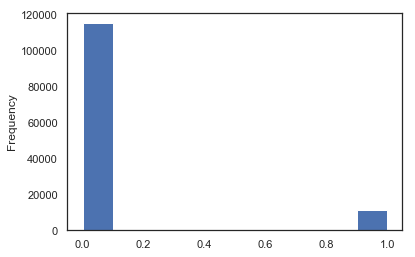

In [214]:
df["isShortlyBeforeBreak"].astype(float).plot.hist()

In [215]:
print(f"Mean in isShortlyBeforeBreak: {df[df['isShortlyBeforeBreak']==True]['time'].mean()} | Global mean: {df['time'].mean()}")

Mean in isShortlyBeforeBreak: 4.094753494691793 | Global mean: 4.06747891904924


In [162]:
# drop unsolved tasks
from sklearn.model_selection import train_test_split
X, y = get_ready_for_training(df_train_time)
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

In [147]:
rf, time = get_feature_importances(X_train, y_train)

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Feature ranking:
1. feature: 'item_order' (0.33711978163845857)
2. feature: 'startSecond' (0.09247778451139824)
3. feature: 'startMinute' (0.09233545808670003)
4. feature: 'student' (0.08156087470419679)
5. feature: 'event_order' (0.06010862061747344)
6. feature: 'item_solution' (0.05058646814704136)
7. feature: 'startHour' (0.0469412778499326)
8. feature: 'startDay' (0.04323974157616138)
9. feature: 'startElapsed' (0.04300621282676384)
10. feature: 'program' (0.03895016330622543)
11. feature: 'item_setting' (0.029929879480044032)
12. feature: 'startDayofweek' (0.027813000807957133)
13. feature: 'startDayofyear' (0.02679595512292569)
14. feature: 'item' (0.011173915114634784)
15. feature: 'startWeek' (0.010231946540255207)
16. feature: 'startMonth' (0.004373307472309879)
17. feature: 'startIs_month_end' (0.0012667012620434126)
18. feature: 'startIs_month_start' (0.0008603536751926944)
19. feature: 'startYear' (0.0005853394115090947)
20. feature: 'startIs_quarter_start' (0.0004632701960

In [148]:
print(rf.oob_score_)

0.13015479974676092


In [149]:
print_score(rf, X_train, y_train, X_valid, y_valid)

[0.3765595527244272,
 0.8908311225474588,
 0.8909841585528061,
 0.3895811459203218]

In [163]:
X["time"] = y
df_train_time_no_start = X
df_train_time_no_start = df_train_time_no_start.drop(["program"], axis=1, errors="ignore")

In [173]:
all_evals = {}

In [174]:
rf_model = RandomForestModelStudentData()
models = [rf_model]
scenarios = [
    'as-observed'
]
%time all_evals["rf_time_data"] = eval_models(models, df_train_time_no_start, scenarios=scenarios, n_experiments_per_scenario=1)

Evaluating RandomForestModelStudentData().
Scenario: 'as-observed'.
Experiments: 

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. Done!
Results: RMSE 0.904 (std nan)

Wall time: 30min 28s


In [175]:
X, y = get_ready_for_training(df_train_time)

indices = np.argsort(rf_model.rf.feature_importances_)[::-1]
print('Feature ranking:')
for f in range(X.shape[1]):
    print(f"{f+1}. feature: '{X.columns[indices[f]]}' ({rf_model.rf.feature_importances_[indices[f]]})")

Feature ranking:
1. feature: 'item_order' (0.34243612438896825)
2. feature: 'startHour' (0.09719464303860997)
3. feature: 'startIs_year_start' (0.09593599029438007)
4. feature: 'student' (0.08607113911458564)
5. feature: 'event_order' (0.06661214688392865)
6. feature: 'item_solution' (0.05727987623570559)
7. feature: 'startIs_year_end' (0.047550796077668524)
8. feature: 'startMinute' (0.04495182507706762)
9. feature: 'startMonth' (0.04232234662642954)
10. feature: 'item_setting' (0.034163727159600046)
11. feature: 'startWeek' (0.027758340484404474)
12. feature: 'startDay' (0.02559574103058357)
13. feature: 'item' (0.01562295969173499)
14. feature: 'startYear' (0.00948030564047129)
15. feature: 'program' (0.0039187582134779615)
16. feature: 'startDayofweek' (0.0010713562369498784)
17. feature: 'startDayofyear' (0.0008471342876849488)
18. feature: 'solved' (0.0004756577846597586)
19. feature: 'startIs_month_start' (0.00041063224746204366)
20. feature: 'startIs_month_end' (0.0002629961283

IndexError: index 22 is out of bounds for axis 0 with size 22

## New dataset based on the previous one: unqiue student-task

In [167]:
students_df = pd.read_csv("students_tasks_attempts.csv")

In [235]:
students_df.head(50)

id  student  task  mean_per_task  std_per_task  \
0    0       29     2       3.178054           0.0   
1    1       29    12       2.890372           0.0   
2    2       29    10       2.302585           0.0   
3    3       29    14       2.890372           0.0   
4    4       29    11       3.295837           0.0   
5    5       29     1       3.135494           0.0   
6    6       29     3       2.995732           0.0   
7    7       29    49       2.639057           0.0   
8    8       29    17       3.713572           0.0   
9    9       29     8       2.833213           0.0   
10  10      584     2       4.976734           0.0   
11  11      584    31       4.110874           0.0   
12  12      584    12       3.850148           0.0   
13  13      584     8       3.970292           0.0   
14  14      584     6       5.043425           0.0   
15  15      584    13       5.308268           0.0   
16  16      584    23       4.477337           0.0   
17  17      584    21       4.330733           0.0   
18  18      584     3       4.394449           0.0   
19  19      584    53       3.555348           0.0   
20  20      584    17       5.081404           0.0   
21  21      584    50       5.521461           0.0   
22  22      584    41       4.143135           0.0   
23  23      584    37       4.174387           0.0   
24  24      584    60       5.897154           0.0   
25  25      584    55       6.326149           0.0   
26  26      769    31       4.736198           0.0   
27  27      769    49       3.178054           0.0   
28  28      909    26       0.000000           0.0   
29  29      917    26       0.000000           0.0   
30  30      971    31       5.030438           0.0   
31  31     1027     2       0.000000           0.0   
32  32     1181    17       0.000000           0.0   
33  33     1218    31       0.000000           0.0   
34  34     1219    44       3.178054           0.0   
35  35     1219    19       0.000000           0.0   
36  36     1219     2       3.135494           0.0   
37  37     1219    31       2.995732           0.0   
38  38     1219    23       4.304065           0.0   
39  39     1219    10       2.772589           0.0   
40  40     1219    12       3.135494           0.0   
41  41     1219    13       5.043425           0.0   
42  42     1219    21       0.000000           0.0   
43  43     1219    38       0.000000           0.0   
44  44     1219     8       3.178054           0.0   
45  45     1282     8       5.164786           0.0   
46  46     1282    12       4.418841           0.0   
47  47     1282    14       0.000000           0.0   
48  48     1287     8       0.000000           0.0   
49  49     1321    23       0.000000           0.0   

                         start      time  n_of_solved  s_since_last_solved  \
0   2017-11-10 12:20:05.152265  3.178054            1             0.000000   
1   2017-11-10 12:20:32.155447  2.890372            1            27.003182   
2   2017-11-10 12:20:54.080259  2.302585            1            21.924812   
3   2017-11-10 12:21:06.966330  2.890372            1            12.886071   
4   2017-11-10 12:21:33.061485  3.295837            1            26.095155   
5   2017-11-10 12:22:14.768707  3.135494            1            41.707222   
6   2017-11-10 12:22:42.455442  2.995732            1            27.686735   
7   2017-11-10 12:23:06.409399  2.639057            1            23.953957   
8   2017-11-10 12:23:23.127216  3.713572            1            16.717817   
9   2017-11-10 12:24:07.602156  2.833213            1            44.474940   
10  2017-11-12 08:33:42.535936  4.976734            1             0.000000   
11  2017-11-12 08:36:17.796933  4.110874            1           155.260997   
12  2017-11-12 08:37:31.844203  3.850148            1            74.047270   
13  2017-11-12 08:38:23.728383  3.970292            1            51.884180   
14  2017-11-12 08:39:19.885045  5.043425            1            56.156662   
1

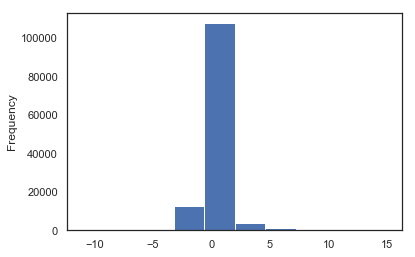

In [232]:
students_df["n_of_solved"].astype(float).plot.hist(10)

In [233]:
display(students_df[students_df["n_of_solved"] == 1].shape)
display(students_df[students_df["n_of_solved"] == 2].shape)

(104211, 18)

(307, 18)

In [237]:
print(f"Mean in is_morning: {students_df[students_df['is_morning']==True]['time'].mean()} | Global mean: {students_df['time'].mean()}")

Mean in is_morning: 4.0345181151219345 | Global mean: 4.057607016023192


In [238]:
print(f"Mean in is_evening: {students_df[students_df['is_evening']==True]['time'].mean()} | Global mean: {students_df['time'].mean()}")

Mean in is_evening: 3.9778470362423195 | Global mean: 4.057607016023192


In [239]:
print(f"Mean in is_afternoon: {students_df[students_df['is_afternoon']==True]['time'].mean()} | Global mean: {students_df['time'].mean()}")

Mean in is_afternoon: 4.164121654520398 | Global mean: 4.057607016023192


In [240]:
print(f"Mean in is_night: {students_df[students_df['is_night']==True]['time'].mean()} | Global mean: {students_df['time'].mean()}")

Mean in is_night: 2.9957322735539917 | Global mean: 4.057607016023192


In [241]:
X, y = get_ready_for_training(students_df)
X["time"] = y

In [242]:
rf_model = RandomForestModelStudentData()
models = [rf_model]
scenarios = [
    'as-observed'
]
%time all_evals["rf_student_data"] = eval_models(models, X, scenarios=scenarios, n_experiments_per_scenario=1)

Evaluating RandomForestModelStudentData().
Scenario: 'as-observed'.
Experiments: 

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


KeyError: "None of [Float64Index([               1.0,                1.0, 0.3636363636363637,\n              0.3636363636363637, 0.3636363636363637, 0.3636363636363637,\n              0.3636363636363637, 0.3636363636363637, 0.3636363636363637,\n              0.3636363636363637,\n              ...\n              0.9090909090909092, 0.9090909090909092, 0.9090909090909092,\n              0.9090909090909092, 0.9090909090909092, 0.9090909090909092,\n              0.9090909090909092, 0.9090909090909092, 0.9090909090909092,\n              0.9090909090909092],\n             dtype='float64', length=22627)] are in the [columns]"